# **Deep Learning project - July 2024**

The scope of this project is the design of a deep neural network able to output a segmented mask from an input image.

## **Project Outline:**

[**Task 0**](#task0): package importing and Dataset loading

[**Task 1**](#task1): preprocessing

[**Task 2**](#task2): model configuration

[**Task 3**](#task3): hyperparameter tuning

[**Task 4**](#task4): best model, evaluation and visualisation

[**Task 5**](#task5): learning curves

<a name='task0'></a>
# Task 0: importing and loading

In [ ]:
import urllib.request
import zipfile
import os
import pickle as pk

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split, KFold
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Lambda, Dropout, Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, concatenate
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from itertools import product

from IPython.display import Image, display
from PIL import ImageOps

I handled the large dataset by first uploading it to a GitHub repository using Git Large File Storage (Git LFS) due to GitHub's file size limitations. To access the dataset, I downloaded it directly from the GitHub repository using urllib.request.urlretrieve. This method efficiently managed the download process of the large ZIP file. After downloading, i extracted the contents using the zipfile module, which allowed to work with the dataset files. The dataset, stored as a .pkl file, was then loaded into memory using the pickle module, enabling to deserialize the data into Python objects, specifically numpy arrays for the images and masks.

In [ ]:
zip_url = "https://github.com/SofiaFormenti/DL-data/raw/main/input_data.zip"
zip_path, _ = urllib.request.urlretrieve(zip_url)
target_folder = "temp"
os.makedirs(target_folder, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"
with open(data_path, 'rb') as f:
    dd = pk.load(f)

<a name='task1'></a>
# Task 1: Preprocessing

(POINT 2) I verified the input shape (256,256,3) and the mask shape (256,256,1)

In [ ]:
imgs = dd['imgs']
masks = dd['masks']

In [ ]:
# Verify the data
print(f"Images shape: {imgs.shape}")
print(f"Masks shape: {masks.shape}")

Images shape: (1305, 256, 256, 3)
Masks shape: (1305, 256, 256, 1)


array([[[201, 195, 190],
        [225, 219, 214],
        [241, 232, 228],
        ...,
        [228, 219, 210],
        [219, 212, 203],
        [224, 217, 208]],

       [[226, 220, 215],
        [254, 248, 243],
        [255, 255, 251],
        ...,
        [238, 229, 220],
        [237, 230, 221],
        [243, 234, 225]],

       [[248, 241, 238],
        [255, 252, 249],
        [255, 255, 251],
        ...,
        [238, 228, 221],
        [235, 228, 219],
        [230, 221, 212]],

       ...,

       [[225, 220, 221],
        [209, 205, 204],
        [188, 187, 183],
        ...,
        [185, 174, 184],
        [218, 210, 221],
        [173, 168, 177]],

       [[196, 192, 191],
        [202, 198, 197],
        [221, 220, 216],
        ...,
        [137, 127, 139],
        [170, 163, 176],
        [171, 166, 175]],

       [[193, 188, 185],
        [201, 198, 194],
        [252, 248, 247],
        ...,
        [110, 100, 112],
        [126, 117, 130],
        [193, 185, 195]]], dtype=uint8)
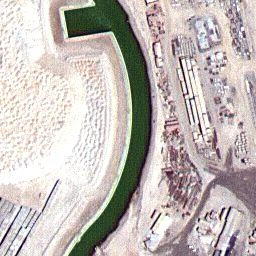

In [ ]:
imgs[0]

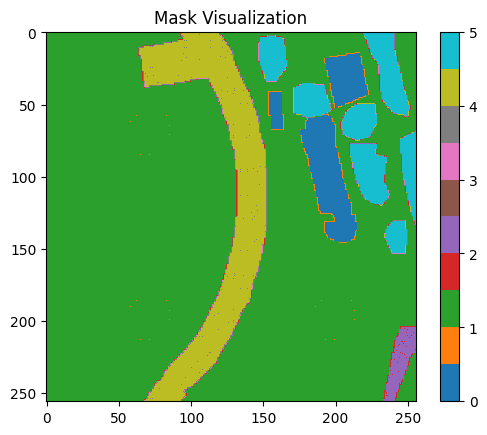

In [ ]:
# Visualize the mask
def visualize_mask(mask):
    plt.imshow(mask, cmap='tab10')
    plt.colorbar()
    plt.title("Mask Visualization")
    plt.show()

# Visualize the first mask
visualize_mask(masks[0])

In [ ]:
unique_imgs, unique_indices = np.unique(imgs, axis=0, return_index=True)
unique_masks = masks[unique_indices]

print(f"Original number of images: {len(imgs)}")
print(f"Number of unique images: {len(unique_imgs)}")

Original number of images: 1305
Number of unique images: 1305


In [ ]:
def get_dataset(batch_size, img_size, input_imgs, target_imgs):
    """Returns a TF Dataset."""

    def load_img_masks(input_img, target_img):
        input_img = tf.image.resize(input_img, img_size)
        input_img = tf.image.convert_image_dtype(input_img, tf.float32)

        target_img = tf.image.resize(target_img, img_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        target_img = tf.image.convert_image_dtype(target_img, tf.uint8)

        return input_img, target_img

    dataset = tf.data.Dataset.from_tensor_slices((input_imgs, target_imgs))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)

    return dataset

I split the dataset into train, validation and test datasets

In [ ]:
img_size = (256,256)
batch_size = 32
num_classes = 6
seed = 42

# split the data based on unique images
train_samples = 400
test_samples = 100

# Shuffle the unique images and masks together
np.random.seed(seed)
indices = np.arange(len(unique_imgs))
np.random.shuffle(indices)
unique_imgs = unique_imgs[indices]
unique_masks = unique_masks[indices]

# Create new splits
train_imgs = unique_imgs[:train_samples]
train_masks = unique_masks[:train_samples]

val_imgs = unique_imgs[train_samples:(len(unique_imgs)-test_samples)]
val_masks = unique_masks[train_samples:(len(unique_imgs)-test_samples)]

test_imgs = unique_imgs[(len(unique_imgs)-test_samples):]
test_masks = unique_masks[(len(unique_imgs)-test_samples):]

print(f"Number of training samples: {len(train_imgs)}")
print(f"Number of validation samples: {len(val_imgs)}")
print(f"Number of test samples: {len(test_imgs)}")


Number of training samples: 400
Number of validation samples: 805
Number of test samples: 100


In [ ]:
train_dataset = get_dataset(batch_size, img_size, train_imgs, train_masks)
val_dataset = get_dataset(batch_size, img_size, val_imgs, val_masks)
test_dataset = get_dataset(batch_size, img_size, test_imgs, test_masks)

Verify the dimensions of inputs and masks after the split

In [ ]:
for batch in train_dataset.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)  # Should be (batch_size, 256, 256, 3)
    print("Target shape:", targets.shape)  # Should be (batch_size, 256, 256, num_classes)

Input shape: (32, 256, 256, 3)
Target shape: (32, 256, 256, 1)


Input image dtype: float32, min: 0.0, max: 1.0
Target image dtype: uint8, min: 0, max: 3


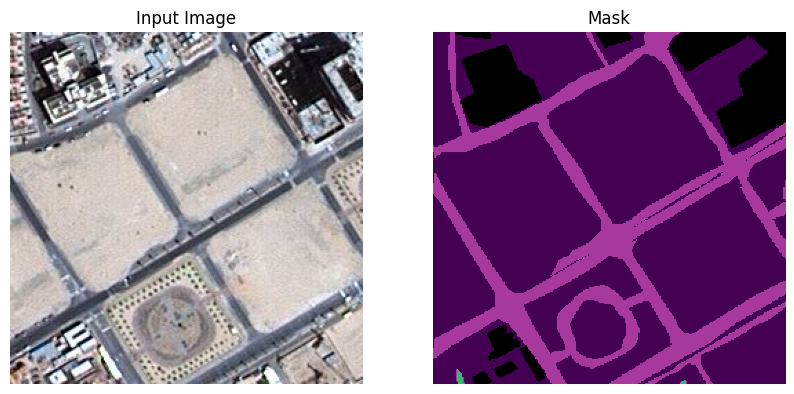

Input image dtype: float32, min: 0.0, max: 1.0
Target image dtype: uint8, min: 0, max: 4


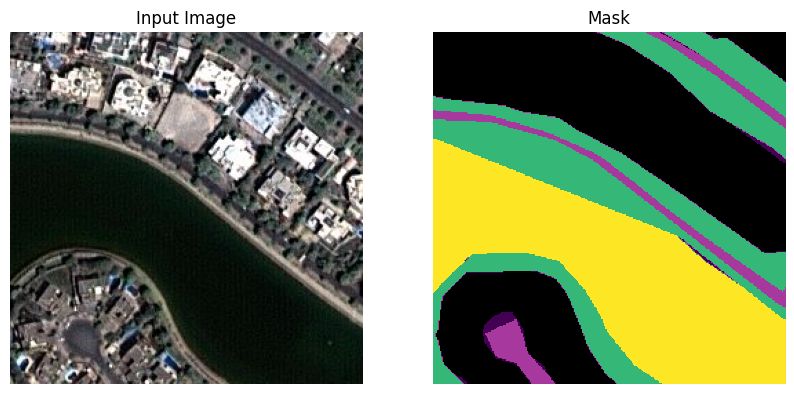

Input image dtype: float32, min: 0.0, max: 1.0
Target image dtype: uint8, min: 0, max: 5


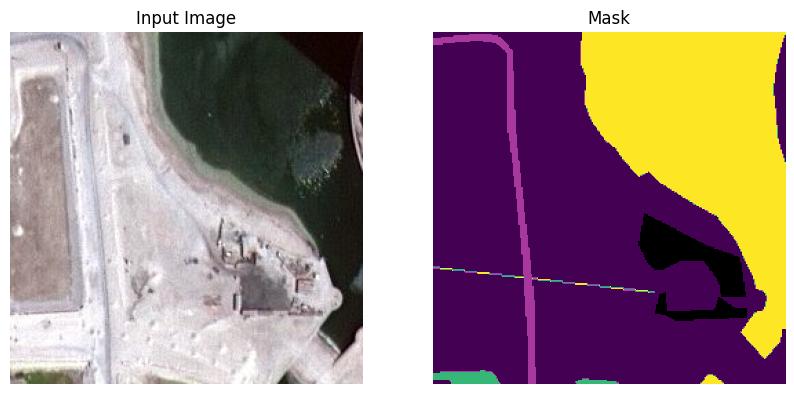

Input image dtype: float32, min: 0.027450980618596077, max: 1.0
Target image dtype: uint8, min: 1, max: 1


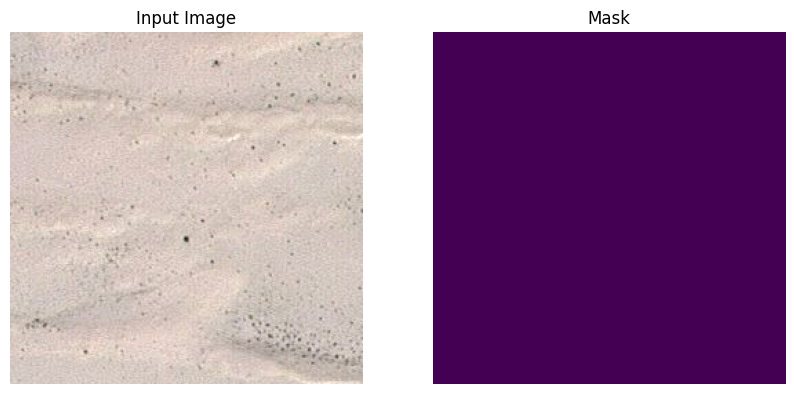

Input image dtype: float32, min: 0.32549020648002625, max: 1.0
Target image dtype: uint8, min: 1, max: 2


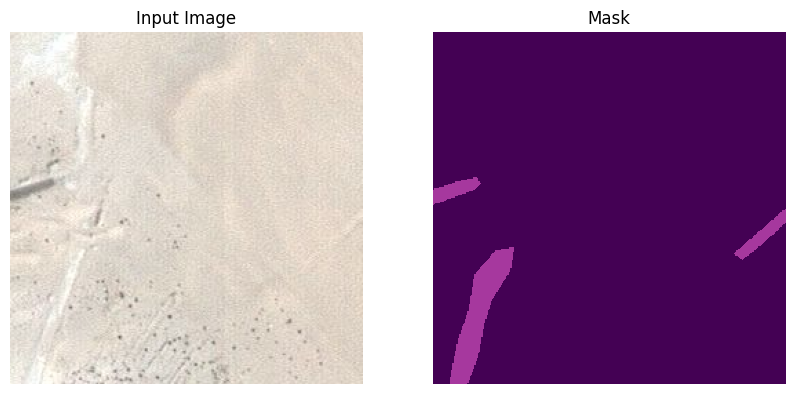

In [ ]:
def visualize_multiple_images(dataset, num_images=5):
    count = 0

    # Define a custom colormap with the given colors
    color_map = {
        0: [0, 0, 0],       # black
        1: [68, 1, 84],     # violet
        2: [166, 56, 158],  # magenta
        3: [53, 183, 120],  # green
        4: [253, 231, 36],  # yellow
        5: [55, 142, 166]   # turquoise
    }
    colors = np.array(list(color_map.values())) / 255.0  # Normalize the RGB values to [0, 1]
    cmap = mcolors.ListedColormap(colors)
    bounds = np.arange(-0.5, 6.5, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    for input_img, target_img in dataset:
        for i in range(input_img.shape[0]):
            if count >= num_images:
                break
            input_image = input_img[i].numpy()
            target_image = target_img[i].numpy()

            # Normalize input image to [0, 1] range if needed
            if input_image.max() > 1.0:
                input_image = input_image / 255.0

            print(f"Input image dtype: {input_image.dtype}, min: {input_image.min()}, max: {input_image.max()}")
            print(f"Target image dtype: {target_image.dtype}, min: {target_image.min()}, max: {target_image.max()}")

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(input_image)
            plt.title('Input Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            # Use the custom colormap to visualize the mask with distinct colors
            plt.imshow(target_image[:, :, 0], cmap=cmap, norm=norm)
            plt.title('Mask')
            plt.axis('off')

            plt.show()

            count += 1
        if count >= num_images:
            break

visualize_multiple_images(train_dataset, num_images=5)

<a name='task2'></a>
# Task 2: Model Configuration

(POINT 1) I use a CNN architecture inspired by the U-net model

(POINT 2) Each pixel takes value in [0,255], so as preprocessing i divide every pixel value by 255, so as to normalize between [0,1].

So after this step the input will still have shape (256,256,3), but the input value domain will be in [0,1]

(POINT 3) **CHANGE** The output of my model is the image mask, with shape (256,256,6), the last layer of the model is a (1,1) convolutional layer, has softmax activation and will return a probability distribution over the six classes, where each channel represents a class and for each pixel the probability distribution of all 6 classes sums up to 1. I'm treating this as a multiclass classification problem

(POINT 4) As loss function i used sparse categorical cross entropy as i'm treating this as a multiclass classification problem

(POINT 5) The configuration is similar to that of the U-net model, it's composed of two blocks, the encoder and the decoder and between I also implemented skip connections.

The encoder block is composed of a succession of convolutional layers, batch normalization, dropout (for regularization and stabilization of the training process) and max pooling for image size reduction. In this downsampling block, each pooling layer reduces the spatial dimensions (height and width) while increasing the depth (number of feature channels) of the feature map.

Between the encoder and the decoder block there is a bottleneck layer which captures the most abstract and high-level features from the input image and is composed of convolutional layers and dropout

The decoder block is composed of a Conv2DTranspose layer, that is the upsampling layers that increases the spatial dimensions of the feature map. In this block there is the implementation of the skip connections which combine the upsampled feature maps with the corresponding feature maps from the encoder to recover spatial information and mirroring the encoder block convolutional layers, batch normalisation and dropout layers.

(POINT 5) As activation function for the hidden layers i used ReLU activation (so as initialization I used He
 initialization)

 **CHANGE** I used same padding instead of valid padding. Using same padding in this case is crucial for maintaining the same spatial dimensions for the output of the input feature maps. Also, i implemented skip connections which to work properly require he encoder and the decoder block to have matching spatial dimension. Overall it's a better decision to use same padding instead of valid as it simplifies the work and removes th need for complex calculations to adjust feature map size.

In [ ]:
def create_model(img_size, num_classes, lr, dropout_rate):
    filters = [8, 12, 16, 20, 24]
    i = 0

    inputs = Input(shape=img_size + (3,))
    s = layers.Lambda(lambda x: x / 255) (inputs)   # NORMALIZATION

    # ENCODER
    c1 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = layers.BatchNormalization()(c1)
    c1 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = Dropout(dropout_rate) (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    i += 1
    c2 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = Dropout(dropout_rate) (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    i += 1
    c3 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = Dropout(dropout_rate) (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    i += 1
    c4 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = Dropout(dropout_rate) (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    i += 1
    c5 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(dropout_rate) (c5)
    c5 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    i -= 1

    # DECODER
    u6 = Conv2DTranspose(filters[i], (2, 2), strides=(2,2),  padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = Dropout(dropout_rate) (c6)
    c6 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = Dropout(dropout_rate) (c6)

    i -= 1
    u7 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = Dropout(dropout_rate) (c7)
    c7 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = Dropout(dropout_rate) (c7)

    i -= 1
    u8 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = Dropout(dropout_rate) (c8)
    c8 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
    c8 = layers.BatchNormalization()(c8)
    c8 = Dropout(dropout_rate) (c8)

    i -= 1
    u9 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = Dropout(dropout_rate) (c9)
    c9 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
    c9 = layers.BatchNormalization()(c9)
    c9 = Dropout(dropout_rate) (c9)


    outputs = Conv2D(num_classes, (1,1), padding='same', activation='softmax') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer= optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=[SparseCategoricalAccuracy()]
    )

    return model

<a name='task3'></a>
# Task 3: Hyperparameter tuning

(POINT 5) I performed hyperparameter tuning for learning rate, dropout rate and batch size. I didn't feel the need to do further hyperparameter tuning

(POINT 6) For tuning hyperparameters i performed holdout, i had already split the train test and validation data at the beginning. I tried Cross validation with early stopping but the computational cost was to high, and therefore i decided to use Holdout.

In [ ]:
# Define your hyperparameter grid
param_grid = {
    "lr": [0.01, 0.001, 0.0001],
    "dropout_rate": [0.1, 0.3, 0.5],  # Ensure values are between 0 and 1
    "batch_size": [16, 32]
}

# Best parameters and accuracy tracking
best_accuracy = 0
best_params = {}

# Define the filepath and checkpoint callback
filepath = "best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Loop through each combination of hyperparameters
for lr, dropout_rate, batch_size in product(param_grid["lr"], param_grid["dropout_rate"], param_grid["batch_size"]):
    # Print current hyperparameters for debugging
    print(f"Training with lr={lr}, dropout_rate={dropout_rate}, batch_size={batch_size}")

    # Create the model with current hyperparameters
    model = create_model(img_size, num_classes, lr, dropout_rate)

    # Ensure datasets are correctly batched
    train_dataset = get_dataset(batch_size, img_size, train_imgs, train_masks)
    val_dataset = get_dataset(batch_size, img_size, val_imgs, val_masks)

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        verbose=2,
        callbacks=callbacks_list
    )

    # Evaluate the model
    val_accuracy = max(history.history['val_sparse_categorical_accuracy'])

    # Update best parameters if current model is better
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = {'lr': lr, 'dropout_rate': dropout_rate, 'batch_size': batch_size}

print("Best parameters found: ", best_params)
print("Best validation accuracy: ", best_accuracy)

Training with lr=0.01, dropout_rate=0.1, batch_size=16
Epoch 1/20
25/25 - 15s - loss: 1.2310 - sparse_categorical_accuracy: 0.5883 - val_loss: 12551.6172 - val_sparse_categorical_accuracy: 0.1347 - 15s/epoch - 617ms/step
Epoch 2/20
25/25 - 5s - loss: 0.8520 - sparse_categorical_accuracy: 0.7240 - val_loss: 72.8118 - val_sparse_categorical_accuracy: 0.1372 - 5s/epoch - 190ms/step
Epoch 3/20
25/25 - 6s - loss: 0.7986 - sparse_categorical_accuracy: 0.7270 - val_loss: 15.6002 - val_sparse_categorical_accuracy: 0.2079 - 6s/epoch - 247ms/step
Epoch 4/20
25/25 - 5s - loss: 0.7678 - sparse_categorical_accuracy: 0.7336 - val_loss: 2.7664 - val_sparse_categorical_accuracy: 0.4976 - 5s/epoch - 195ms/step
Epoch 5/20
25/25 - 5s - loss: 0.7533 - sparse_categorical_accuracy: 0.7363 - val_loss: 2.9061 - val_sparse_categorical_accuracy: 0.3176 - 5s/epoch - 187ms/step
Epoch 6/20
25/25 - 5s - loss: 0.7525 - sparse_categorical_accuracy: 0.7355 - val_loss: 1.2001 - val_sparse_categorical_accuracy: 0.5610 -

Best parameters found:

Learning rate = 0.01

Dropout rate = 0.1

batch size = 16

yield a validation accuracy of 0.816

<a name='task4'></a>
# Task 4: Final model loading, test predictions and visualization, evaluation

(POINT 6) As evaluation metric I used accuracy, as we are in a classification setting.

In [ ]:
# Load the best model
best_model = load_model("best_model.h5")

# Optionally, print the model summary
best_model.summary()

# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 8)          224       ['lambda_1[0][0]']            
                                                                                                  
 batch_normalization_16 (Ba  (None, 256, 256, 8)          32        ['conv2d_19[0][0]']           
 tchNormalization)                                                                          

In [ ]:
# Make predictions on the test dataset
test_preds = best_model.predict(test_dataset)

4/4 [==============================] - 1s 58ms/step


In [ ]:
test_preds[0]

array([[[0.02499539, 0.660207  , 0.1727426 , 0.11682639, 0.01964753,
         0.00558107],
        [0.02818009, 0.69479376, 0.15344039, 0.10417564, 0.01326087,
         0.00614917],
        [0.03022292, 0.72529745, 0.1441841 , 0.08206537, 0.01082739,
         0.00740275],
        ...,
        [0.01817784, 0.793035  , 0.10518387, 0.06387939, 0.01390388,
         0.00581999],
        [0.02315731, 0.70850086, 0.12674686, 0.1176667 , 0.0175375 ,
         0.00639073],
        [0.02550786, 0.5946377 , 0.20163451, 0.1496269 , 0.02268285,
         0.00591014]],

       [[0.02319964, 0.7537966 , 0.13850546, 0.06722015, 0.01159611,
         0.00568204],
        [0.02644567, 0.8083596 , 0.09771041, 0.05393318, 0.00607506,
         0.00747611],
        [0.02766694, 0.80754364, 0.10596962, 0.04548944, 0.00483158,
         0.00849871],
        ...,
        [0.01131019, 0.8884488 , 0.06333527, 0.02512114, 0.00641071,
         0.00537396],
        [0.01702384, 0.8244506 , 0.08819409, 0.05447192, 0.009

In [ ]:
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# Print the entire array
print(test_masks[6])

[[[1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [1]
  [1]
  [1]
  [1]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [2]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1

In [ ]:
prova_prevista = np.argmax(test_preds[6], axis=-1)
prova_prevista

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,

In [ ]:
test_imgs[6]

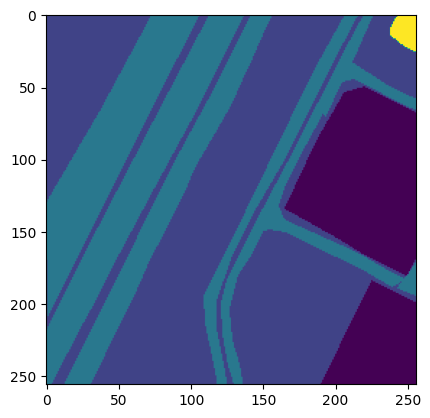

In [ ]:
plt.imshow(test_masks[6])

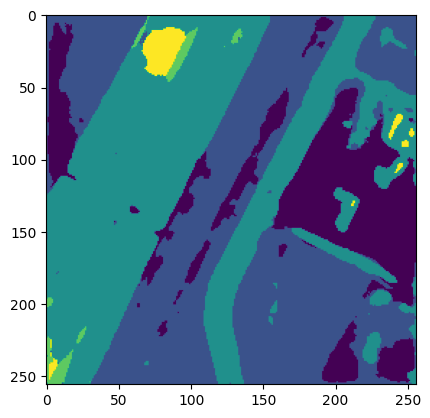

In [ ]:
plt.imshow(np.argmax(test_preds[6], axis=-1))

In [ ]:
print("Shape of test_masks:", test_masks[0].shape)  # Should be (height, width)
print("Shape of test_preds:", test_preds[0].shape)  # Should be (height, width, num_classes)

Shape of test_masks: (256, 256, 1)
Shape of test_preds: (256, 256, 6)


In [ ]:
# Define a color map where each class label is mapped to a specific color
color_map = {
    0: [0, 0, 0],       # black
    1: [68, 1, 84],     # violet
    2: [166, 56, 158],     # magenta
    3: [53, 183, 120],     # green
    4: [253, 231, 36],   # yellow
    5: [55, 142, 166]    #turquois
}

def apply_color_map(mask, color_map):
    """Apply color map to a mask."""
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for label, color in color_map.items():
        color_mask[mask == label] = color
    return color_mask

nimg = 10  # Number of images to display
for i in range(nimg):
    print(f"----- Test Image: {i} -----")

    plt.figure(figsize=(15, 5))

    # Display input image
    plt.subplot(1, 3, 1)
    plt.title(f"Input Image {i}")
    plt.imshow(test_imgs[i])
    plt.axis('off')

    # Display ground-truth target mask
    plt.subplot(1, 3, 2)
    plt.title(f"Ground Truth Mask {i}")
    ground_truth_mask = test_masks[i]
    # Remove singleton dimension if it exists
    if ground_truth_mask.ndim == 3 and ground_truth_mask.shape[-1] == 1:
        ground_truth_mask = np.squeeze(ground_truth_mask, axis=-1)  # Remove the last dimension
    colored_ground_truth_mask = apply_color_map(ground_truth_mask, color_map)
    plt.imshow(colored_ground_truth_mask)
    plt.axis('off')

    # Display mask predicted by our model
    plt.subplot(1, 3, 3)
    plt.title(f"Predicted Mask {i}")
    pred_mask = np.argmax(test_preds[i], axis=-1)  # Convert to label format if needed
    colored_pred_mask = apply_color_map(pred_mask, color_map)
    plt.imshow(colored_pred_mask)
    plt.axis('off')

    plt.show()

<a name='task5'></a>
# Task 5: Learning Curves

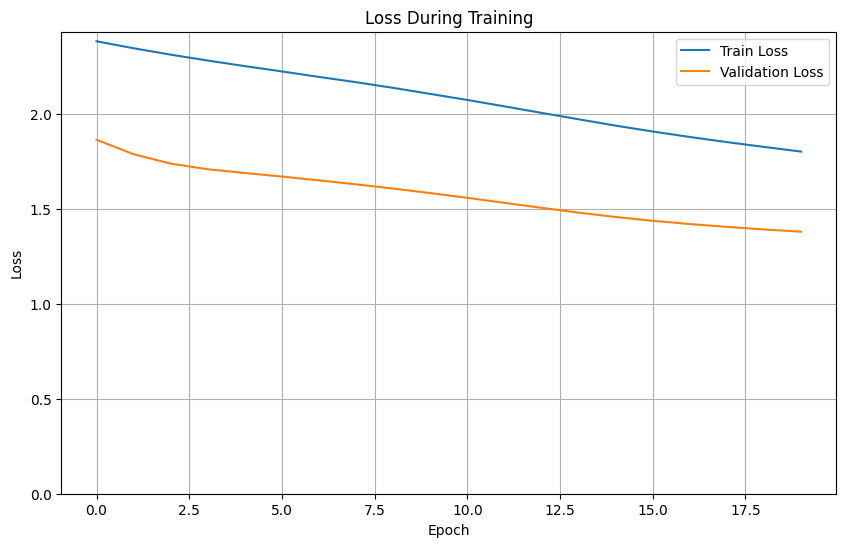

In [ ]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))

    # Plot Loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()
    plt.ylim(bottom=0)  # Set bottom limit to 0 to zoom out and see the loss trend clearly

    plt.grid(True)  # Optional: Add grid for better readability
    plt.show()

# Assuming `history` is your training history object from model.fit
plot_loss(history)

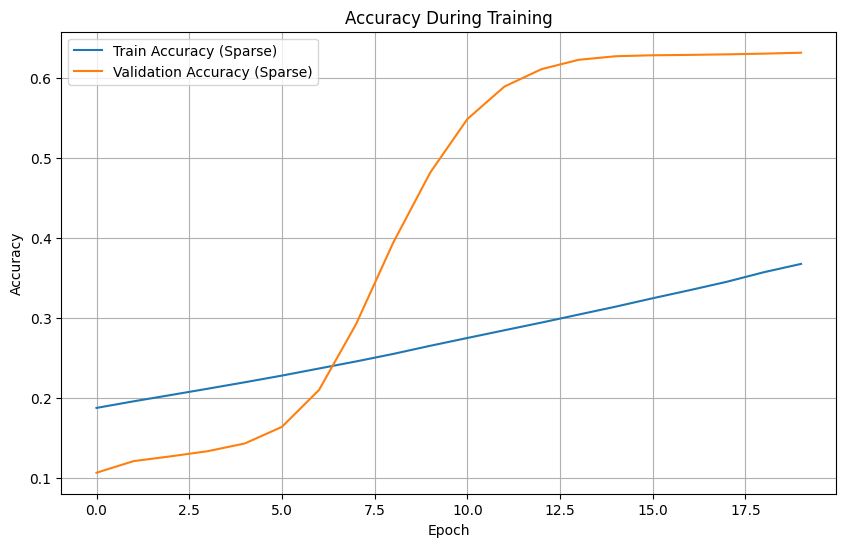

In [ ]:
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))

    # Plot Accuracy
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    if 'sparse_categorical_accuracy' in history.history:
        plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy (Sparse)')
    if 'val_sparse_categorical_accuracy' in history.history:
        plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy (Sparse)')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy During Training')
    plt.legend()

    plt.grid(True)  # Optional: Add grid for better readability
    plt.show()

# Assuming `history` is your training history object from model.fit
plot_accuracy(history)